In [1]:
import matplotlib.pyplot as mpl
import scipy.cluster.hierarchy as sch
import random, numpy as np, pandas as pd
from scipy.optimize import minimize

In [2]:
#Equally Weighted Portfolio
def ewPortfolio(n):
    return n*[1/n]

In [3]:
#Risk Parity
def calculate_risk_contribution(w,V):
    # function that calculates asset contribution to total risk
    w = np.matrix(w)
    sigma = np.sqrt(calculate_portfolio_var(w,V))
    # Marginal Risk Contribution
    MRC = np.dot(V,w.T)
    # Risk Contribution
    RC = np.multiply(MRC,w.T)/sigma
    return RC

def risk_budget_objective(x,pars):
    # calculate portfolio risk
    V = pars[0]# covariance table
    x_t = pars[1] # risk target in percent of portfolio risk
    sig_p =  np.sqrt(calculate_portfolio_var(x,V)) # portfolio sigma
    risk_target = np.asmatrix(np.multiply(sig_p,x_t))
    asset_RC = calculate_risk_contribution(x,V)
    J = sum(np.square(asset_RC-risk_target.T)) # sum of squared error
    return J

def risk_parity(riskbudget,w0,V):
    x_t = riskbudget # your risk budget percent of total portfolio risk (equal risk)
    cons = ({'type': 'eq', 'fun': total_weight_constraint},
    {'type': 'ineq', 'fun': long_only_constraint})
    res= minimize(risk_budget_objective, w0, args=[V,x_t], method='SLSQP',constraints=cons) 
    return res

In [4]:
#Global minimum variance
def GMVPortfolio(covMatrix):
    return np.dot(np.linalg.inv(covMatrix),
                  np.ones(len(covMatrix)))/np.dot(np.dot(np.transpose(np.ones(len(covMatrix))),
                                                  np.linalg.inv(covMatrix)),np.ones(len(covMatrix)))

In [5]:
#Inverse variance portfolio (Risk parity fra De Prado)
def getIVP(cov,**kargs):
    #Compute the inverse-variance portfolio
    ivp=1./np.diag(cov)
    ivp/=ivp.sum()
    return ivp

In [6]:
#Maximum diversification
def calculate_portfolio_var(w,V):
    # function that calculates portfolio risk
    return (np.dot(np.dot(w,V),w.T))

def calc_diversification_ratio(w, V):
    # average weighted vol
    w_vol = np.dot(np.sqrt(np.diag(V)), w.T)
    # portfolio vol
    port_vol = np.sqrt(calculate_portfolio_var(w, V))
    diversification_ratio = w_vol/port_vol
    # return negative for minimization problem (maximize = minimize -)
    return -diversification_ratio

def total_weight_constraint(x):
    return np.sum(x)-1

def long_only_constraint(x):
    return x

def max_div_port(w0, V, bnd=None, long_only=True):
    # w0: initial weight
    # V: covariance matrix
    # bnd: individual position limit
    # long only: long only constraint
    cons = ({'type': 'eq', 'fun': total_weight_constraint},)
    if long_only: # add in long only constraint
        cons = cons + ({'type': 'ineq', 'fun':  long_only_constraint},)
    res = minimize(calc_diversification_ratio, w0, bounds=bnd, args=V, method='SLSQP', constraints=cons)
    return res

In [7]:
#HRP
def getClusterVar(cov,cItems):
    #Compute variance per cluster
    cov_=cov.loc[cItems,cItems] # matrix slice
    w_=getIVP(cov_).reshape(-1,1)
    cVar=np.dot(np.dot(w_.T,cov_),w_)[0,0]
    return cVar

def getQuasiDiag(link):
    # Sort clustered items by distance
    link=link.astype(int)
    sortIx=pd.Series([link[-1,0],link[-1,1]])
    numItems=link[-1,3] #number of original items
    while sortIx.max()>=numItems:
        sortIx.index=range(0,sortIx.shape[0]*2,2) #make space
        df0=sortIx[sortIx>=numItems] # find clusters
        i = df0.index;j=df0.values-numItems
        sortIx[i]=link[j,0] # item 1
        df0=pd.Series(link[j,1],index=i+1)
        sortIx=sortIx.append(df0) # item 2
        sortIx=sortIx.sort_index() #re-sort
        sortIx.index=range(sortIx.shape[0]) # re-index
    return sortIx.tolist()

def getRecBipart(cov,sortIx):
    # Compute HRP alloc
    w=pd.Series(1,index=sortIx)
    cItems=[sortIx] # initialize all items in one cluster
    while len(cItems)>0:
        cItems=[i[j:k] for i in cItems for j,k in ((0,len(i)//2),(len(i)//2,len(i))) if len(i)>1] # bi-section
        for i in range(0,len(cItems),2):
            cItems0=cItems[i] # cluster 1
            cItems1=cItems[i+1] # cluster 2
            cVar0=getClusterVar(cov,cItems0)
            cVar1=getClusterVar(cov,cItems1)
            alpha=1-cVar0/(cVar0+cVar1)
            w[cItems0]*=alpha # weight 1
            w[cItems1]*=1-alpha # weight 2
            
    return w

def correlDist(corr):
    # A distance matrix based on correlation, where 0<=d[i,j]<=1
    #This is a proper diastance metric
    dist=((1-corr)/2.)**.5 # distance matrix
    return dist


def plotCorrMatrix(path,corr,labels=None):
    #Heatmap of the correlation matrix
    if labels is None: labels=[]
    mpl.pcolor(corr)
    mpl.colorbar()
    mpl.yticks(np.arange(.5,corr.shape[0]+.5),labels)
    mpl.xticks(np.arange(.5,corr.shape[0]+.5),labels)
    mpl.savefig(path)
    mpl.clf();mpl.close()  #reset pylab
    return
    
def generateData(nObs,size0,size1,sigma1,x=np.empty((0,1))):
    #Time series of correlated variables
    #1)generating some uncorrelated data
    np.random.seed(seed=12345);random.seed(12345)
    if len(x)==0:
        x=np.random.normal(0,1,size=(nObs,size0)) # each row is a variable
    #2) creating correlation between the variables
    cols=[random.randint(0,size0-1) for i in range(size1)]
    q=np.random.normal(0,sigma1,size=(nObs,len(cols)))
    y=x[:,cols]+q
    x=np.append(x,y,axis=1)
    x=pd.DataFrame(x,columns=range(1,x.shape[1]+1))
    return x,cols

def generateAutocorrelatedData(nObs,correlation,size):
    x=np.random.normal(0,1,size=(1,size))
    for i in range(nObs-1):
        x=np.append(x,correlation*x[i]+np.random.normal(0,1,size=(1,size)),axis=0)
    return x

def generateCauchyDistData(nObs,size):
    x=np.random.standard_cauchy(size=(nObs,size))
    return pd.DataFrame(x)

def generateT_DistData(nObs,size,df):
    x=np.random.standard_t(df,size=(nObs,size))
    return pd.DataFrame(x)
    
def findCorrelatedCols(colnbs,size0):
    keys = list(set([i[0] for i in colnbs]))
    for i in range(1,size0+1):
        if i not in keys:
            keys.append(i)     
    keys.sort()
    clusters={key: [key] for key in keys}
    for i in colnbs:
        clusters[i[0]].append(i[1])
    return clusters

def clusterWeights(clusters, hrp):
    weights={key:None for key in clusters.keys()}
    for i in weights:
        weights[i] = sum([hrp.loc[j] for j in clusters[i]])
    return list(weights.values())
    
    
def main():
    #1) Generate correlated data
    nObs, size0,size1,sigma1,correlation = 1000,5,10,0.5,-1
    #x = generateAutocorrelatedData(nObs,correlation,size0)
    x, cols=generateData(nObs,size0,size1,sigma1)
    print(findCorrelatedCols([(j+1,size0+i) for i,j in enumerate(cols,1)],size0))
    cov,corr=x.cov(),x.corr()
    # 2) compute and plot correl matrix
    #corr=pd.DataFrame(np.array([[1,0.7,0.2],[0.7,1,-0.2],[0.2,-0.2,1]]))
    plotCorrMatrix('HRP3_corr0.png',corr,labels=corr.columns)
    # 3) cluster
    dist=correlDist(corr)
    link=sch.linkage(dist,'single')
    sortIx=getQuasiDiag(link)
    sortIx=corr.index[sortIx].tolist() #recover labels
    df0=corr.loc[sortIx,sortIx] #re-order
    plotCorrMatrix('HRP3_corr1.png',df0,labels=df0.columns)
    #4) Capital allocation
    hrp=getRecBipart(cov,sortIx)
    
    plot_weights(hrp, cov, x)
    
    return hrp


def testStability():
    nObs, size0,size1,sigma1,recalc_time, samplesize,correlation = 528,5,5,0.5,22,264,0
    #x = generateAutocorrelatedData(nObs,correlation,size0)
    x,cols=generateData(nObs,size0,size1,sigma1)
    clusters=findCorrelatedCols([(j+1,size0+i) for i,j in enumerate(cols,1)],size0)
    clusterweights=[]
    weights=[]
    print(clusters)
    for i in range(int((nObs-samplesize)/recalc_time)+1):
        x_sample = x.iloc[i*recalc_time:samplesize+recalc_time*i]
        cov,corr=x_sample.cov(),x_sample.corr()
        dist=correlDist(corr)
        link=sch.linkage(dist,'single')
        sortIx=getQuasiDiag(link)
        sortIx=corr.index[sortIx].tolist() #recover labels
        df0=corr.loc[sortIx,sortIx] #re-order
        hrp=getRecBipart(cov,sortIx)
        plotCorrMatrix('HRP3_corr{}.png'.format(i),df0,labels=df0.columns)
        clusterweights.append(clusterWeights(clusters,hrp))
        weights.append(list(hrp.values))
        print(hrp)
    return pd.DataFrame(weights)
    return pd.DataFrame(clusterweights)

In [8]:
def risk_contribution(weights,cov):
    portvar = np.dot(np.dot(weights,cov),weights.T)
    rc=[(weights[i]*np.dot(cov,weights)[i])/portvar for i in range(len(weights))]
    return rc
    
    

In [40]:
#Barplots of allocations
def plot_weights(hrp, cov, data):
    index = list(data.columns)
    
    #HRP
    hrp = hrp.sort_values(ascending=False)
    hrp.plot.bar(figsize = (15,7))
    mpl.title("HRP")
    mpl.ylabel("Weight")
    mpl.xlabel("Asset")
    mpl.ylim((0, 0.5))
    mpl.show()

    #Naive Risk-Parity
    ivp = getIVP(cov)
    ivp = pd.Series(ivp, index=index)
    ivp = ivp.sort_values(ascending=False)
    ivp.plot.bar(figsize = (15,7))
    mpl.title("Naive Risk parity (IVP)")
    mpl.ylabel("Weight")
    mpl.xlabel("Asset")
    mpl.ylim((0,0.5))
    mpl.show()
    
    #Risk Parity
    rp = risk_parity(np.array([1/len(cov)]*len(cov)),np.array([1/len(cov)]*len(cov)),cov).x
    rp = pd.Series(rp, index=index)
    rp = rp.sort_values(ascending=False)
    rp.plot.bar(figsize = (15,7))
    mpl.title("Risk Parity")
    mpl.ylabel("Weight")
    mpl.xlabel("Asset")
    mpl.ylim((0, 0.5))
    mpl.show()
    
    #GMV
    gmv = GMVPortfolio(cov)
    gmv = pd.Series(gmv, index=index)
    gmv = gmv.sort_values(ascending=False)
    gmv.plot.bar(figsize = (15,7))
    mpl.title("GMV")
    mpl.ylabel("Weight")
    mpl.xlabel("Asset")
    mpl.ylim((-0.1, 0.5))
    mpl.show()
    
    #Maximum_Div_port
    mdv = pd.Series(max_div_port(np.array([1/len(cov)]*len(cov)),cov).x, index=index)
    mdv = mdv.sort_values(ascending=False)
    mdv.plot.bar(figsize = (15,7))
    mpl.title("Maximum Diversification Portfolio")
    mpl.ylabel("Weight")
    mpl.xlabel("Asset")
    mpl.ylim((-0.1, 0.5))
    mpl.show()
    

{1: [1, 7], 2: [2, 10, 14], 3: [3, 8, 9, 11, 15], 4: [4, 6, 13], 5: [5, 12]}


/Users/magnustveter/Documents/Nordnet/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:118: ClusterWarning: scipy.cluster: The symmetric non-negative hollow observation matrix looks suspiciously like an uncondensed distance matrix


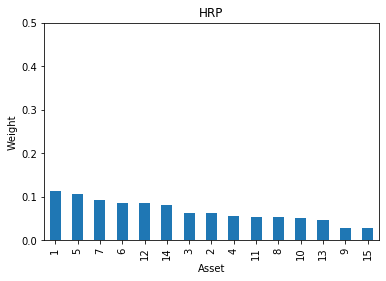

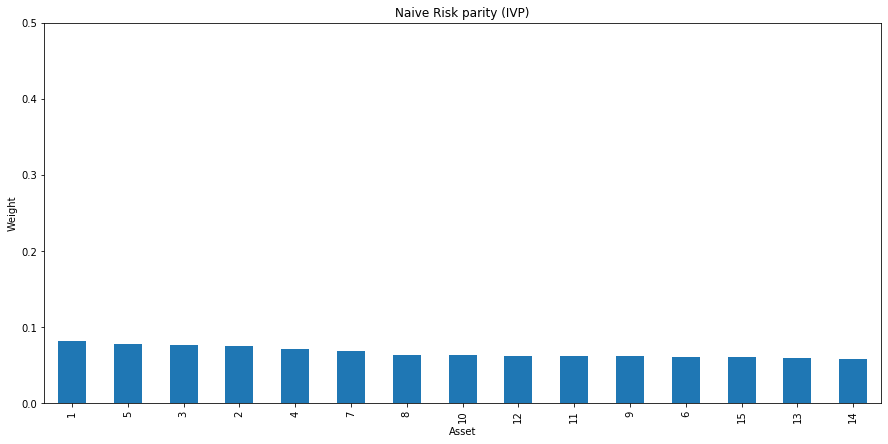

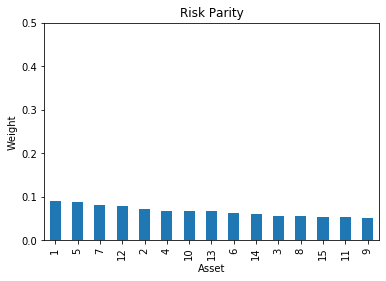

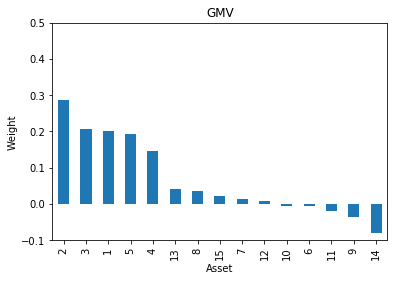

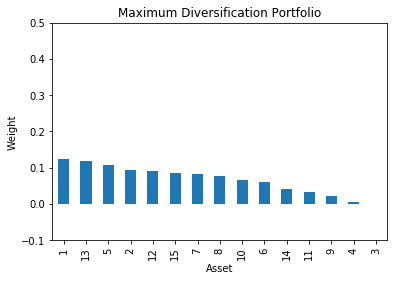

11    0.052035
15    0.028002
9     0.028736
3     0.063030
8     0.051995
10    0.051740
2     0.062092
14    0.081139
6     0.085112
4     0.055974
13    0.046177
5     0.105138
12    0.084696
1     0.111757
7     0.092377
dtype: float64

In [39]:
main()

In [44]:
#data fra excel fil arp_strategies
for i in range(5):
    arp_data = pd.read_excel("arp_strategies.xlsx", sheet_name="S_{}".format(i+1))
    arp_data = arp_data.iloc[3000:3500] #nogle strategier starter først fra 2005, så de første 2611 rækker fjernes
    arp_data = arp_data.drop(['Date'], axis=1)
    if i == 0:
        arp_data_samlet = arp_data
    else:
        arp_data_samlet = pd.merge(arp_data_samlet,arp_data,right_index = True, left_index = True)

arp_data = arp_data_samlet        
arp_data.head()

,S_11,S_12,S_13,S_14,S_15,S_16,S_17,S_21,S_22,S_23,...,S_45,S_46,S_47,S_51,S_52,S_53,S_54,S_55,S_56,S_57
3000,0.000712,0.000860,-0.000231,0.000478,0.000869,-0.002458,0.003165,0.001137,0.001133,-0.002092,...,-0.000294,-0.000876,0.004545,0.000191,-0.000045,0.001742,-0.000340,-0.000619,0.001232,0.008843
3001,-0.000915,0.000908,-0.000321,-0.000867,0.001068,-0.003567,-0.000741,0.001702,-0.001983,-0.000326,...,-0.000123,-0.000041,-0.000881,-0.000189,0.000262,0.000041,-0.000769,0.001978,-0.001137,-0.000497
3002,-0.001244,0.000057,0.000650,-0.000744,-0.001052,-0.005006,0.004143,-0.000758,0.000725,-0.000285,...,-0.000509,0.002367,-0.001896,-0.000908,-0.000573,-0.001036,0.000362,-0.000249,-0.003951,-0.000651
3003,0.000387,0.000957,0.000702,-0.000456,-0.000250,0.001879,-0.000996,-0.001584,0.002330,-0.001601,...,-0.001039,-0.000666,0.004417,-0.002227,0.000173,-0.000443,0.000844,0.000753,0.005187,0.001703
3004,0.001583,0.000871,0.001179,0.000859,0.000641,0.001300,0.000607,-0.000553,-0.000934,0.000685,...,0.001341,-0.000180,0.000270,0.001503,0.000014,0.000604,-0.001207,0.001242,-0.002193,-0.003329


In [36]:
def main_2():
    #1) data
    x = arp_data
    cov,corr=x.cov(),x.corr()
    # 2) compute and plot correl matrix
    #corr=pd.DataFrame(np.array([[1,0.7,0.2],[0.7,1,-0.2],[0.2,-0.2,1]]))
    plotCorrMatrix('HRP3_corr0.png',corr,labels=corr.columns)
    # 3) cluster
    dist=correlDist(corr)
    link=sch.linkage(dist,'single')
    sortIx=getQuasiDiag(link)
    sortIx=corr.index[sortIx].tolist() #recover labels
    df0=corr.loc[sortIx,sortIx] #re-order
    plotCorrMatrix('HRP3_corr1.png',df0,labels=df0.columns)
    #4) Capital allocation
    hrp=getRecBipart(cov,sortIx)
    
    plot_weights(hrp, cov, x)
    
    return hrp

/Users/magnustveter/Documents/Nordnet/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:10: ClusterWarning: scipy.cluster: The symmetric non-negative hollow observation matrix looks suspiciously like an uncondensed distance matrix
  # Remove the CWD from sys.path while we load stuff.


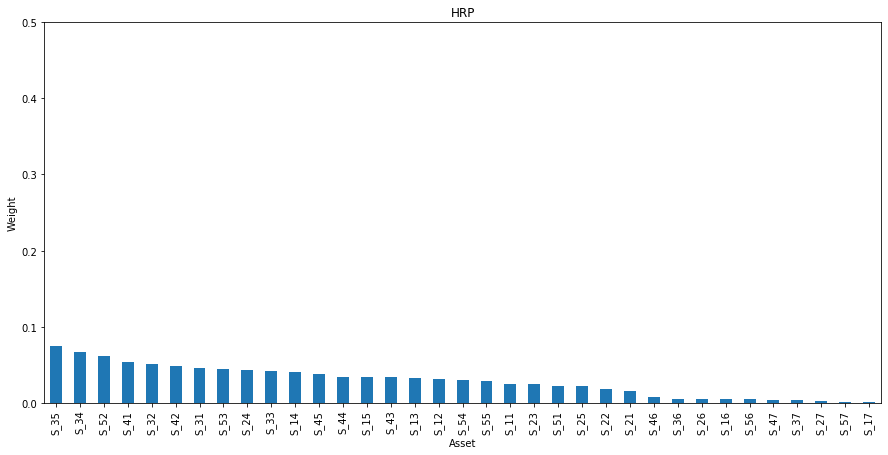

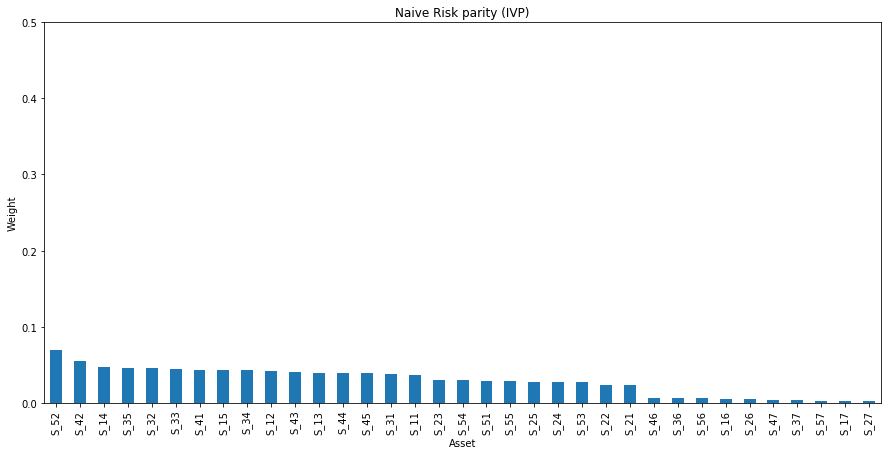

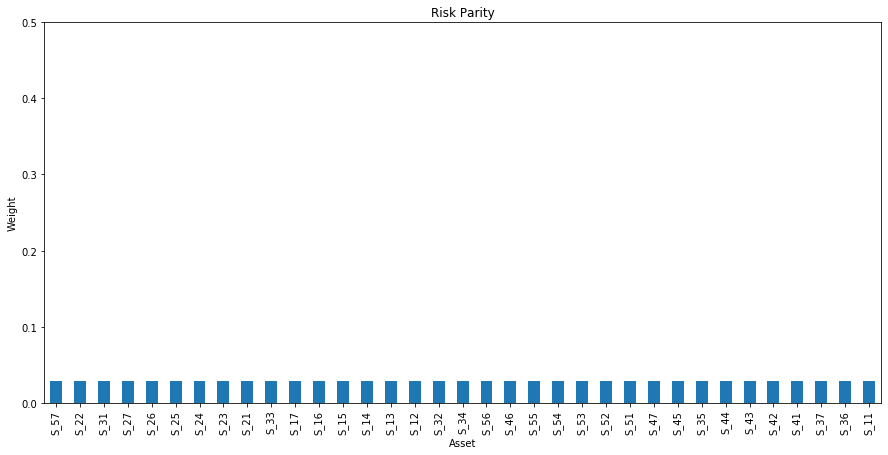

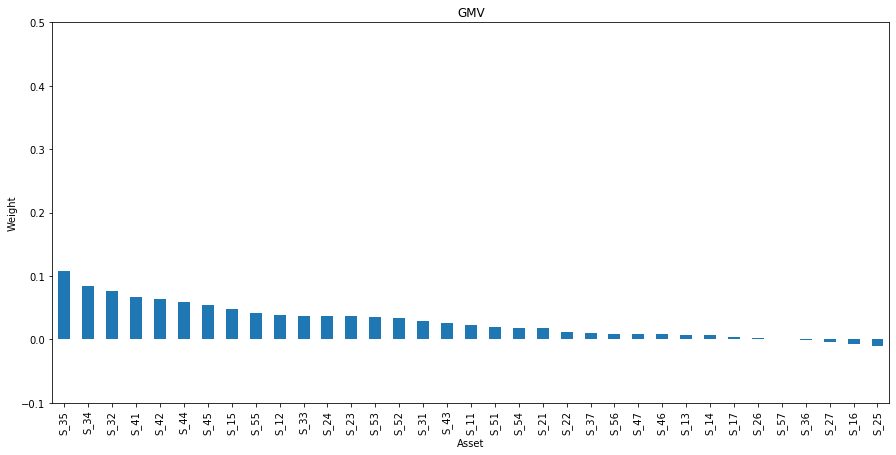

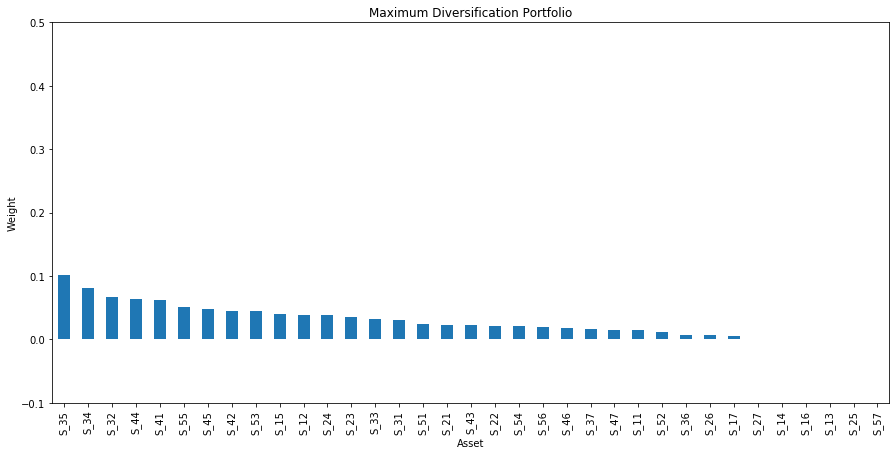

S_53    0.043829
S_35    0.074536
S_34    0.066628
S_24    0.042771
S_14    0.040568
S_44    0.034329
S_54    0.029444
S_45    0.038036
S_52    0.061218
S_42    0.048733
S_12    0.031252
S_22    0.017847
S_25    0.022197
S_15    0.034321
S_55    0.028706
S_41    0.053341
S_31    0.045658
S_21    0.015573
S_11    0.025142
S_51    0.022613
S_56    0.004485
S_32    0.050396
S_46    0.007532
S_26    0.005435
S_16    0.004620
S_13    0.032771
S_33    0.041133
S_36    0.005537
S_47    0.004074
S_37    0.003208
S_57    0.001676
S_17    0.001557
S_27    0.002050
S_23    0.024973
S_43    0.033809
dtype: float64

In [45]:
main_2()